___
# Projeto Final
**Estudante: Nathan Augusto Zacarias Xavier**

# Introdução

O Projeto Final em destaque, visa implementar a técnica de Fusão de Dados a partir do Filtro de Kalman Estendido e verificar como o processo de fusão de dados é importante diante da navegação de um robô em um ambiente *indoor*, tendo poucos recursos disponíveis para localização.

Para o desenvolvimento desse projeto, considerou-se a utilização de sinais *wireless* dispostas no ambiente de modo a verificar a capacidade do robô se localizar em um ambiente onde sistemas como o GPS não seriam suficientes para realizar tal medição.

In [3]:
# Bibliotecas de Interesse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Ellipse
import random
import seaborn as sns
import imageio
import math
import networkx as nx
import time
from scipy.interpolate import interp1d
from scipy.linalg import sqrtm
from skimage.draw import line
from scipy.stats import norm
from scipy.stats import multivariate_normal

# Filtro de Kalman Estendido

O Filtro de Kalman Estendido (*Extended Kalman Filter* - EKF) foi escolhido diante da ampla utilização nas aplicações de robótica móvel, além da fácil implementação e robustez quando aplicado em ambientes em geral. O filtro depende de dois estágio distintos no processamento dos dados: 1) A etapa de Previsão e 2) a Correção das estimações.

A etapa de Previsão é implementada visando estimar estados a partir de um modelo matemático do sistema e características estatísticas de covariância entre os estados, conforme demonstrado a seguir:

$$ \hat{x}^{-{}}_{k} = \hat{x}_{k-1} +f(x,u,k)\cdot dt $$
$$ P_k = F_k * P_{k-1} * F_k +Q_k $$

A segunda parte, de Correção, somente é desenvolvida quando são observadas medições de sensores que visam atualizar os estados estimados e inovar as covariâncias, além de calcular o ganho de Kalman que tem como objetivo otimizar as estimações. Todo o cálculo de correção é feito como mostrado:

$$ K_k = P_k * H^T_k * \left( H_k * P_k * H^T_k +R_k \right)^{-1} $$
$$ \hat{x}_k = \hat{x}^{-{}}_{k} +K_k * \left(Z -h \left(\hat{x}^{-{}}_{k}, k \right) \right) $$
$$ P_k = (I -K_k * H_k) *P_k $$

Da formulação, do Filtro de Kalman, tem-se:
- $\hat{x}_k$ os estados estimados do sistema no instante $k$, além de $\hat{x}^{-{}}$ referente ao estados estimados *a priori* na etapa de predição;

- Três Matrizes de Covariância:
 - $Q_k$ associado ao Erro de Modelagem;
 - $R_k$ referente aos Erros de Medição dos sensores, e;
 - $P_k$ que é a Matriz de Covariância dos Estados.

A dinamicidade do Filtro de Kalman é apresentada a partir dos termos:
- $f(x,u,k)$ que referente aos estados, e;
- $h(x,k)$ que associa as medições aos estados do sistema às medições dos sensores,

e suas respectivas Matrizes Jacobianas:
$$ F_k = \frac{\partial f_k}{\partial \hat{x}_{k-1}} $$
$$ H_k = \frac{\partial h_k}{\partial \hat{x}^{-{}}_{k}} $$

Os valores de $Z$ são obtidos a partir das medições dos sensores, de modo que o termo $\left(Z -h \left(\hat{x}^{-{}}_{k}, k \right) \right)$ indica o erro de entre o que o sensores medem e os valores estimados. E, por fim, a matriz de Ganho de Kalman $K_k$.

## Modelagem do Sistema

Sendo o projeto aplicado sobre um robô que se desloca sobre o plano, conforme imagem, considera-se um vetor de estados $\mathbf{x}$ tal que:

$$ \mathbf{x} = \begin{bmatrix} x \\ y \\ \theta \end{bmatrix}$$

sendo $x$ e $y$ as posições espaciais do plano e $\theta$ a rotação. São consideradas as notações $(X_R,Y_R)$ para identificar as posições do robô relativas às coordenadas globais $(X_G,Y_G)$.

![Modelo](Model_Robo.png)

Para a etapa de previsão, portanto, a modelagem do sistema é feita de modo que:
$$ f(x,u,k) = \begin{bmatrix} \sqrt{x^2 +y^2} \cdot cos(\theta) \\ \sqrt{x^2 +y^2} \cdot sin(\theta) \\ \theta \end{bmatrix} ~~~~~\rightarrow~~~~~ F_k = \begin{bmatrix} 1 & 0 & -sin(\theta) \\ 0 & 1 & cos(\theta) \\ 0 & 0 & 1 \end{bmatrix} $$


### Validação da Etapa de Previsão do EKF

Buscando verificar, na prática, as etapas do EKF, a primeira etapa busca demonstrar o impacto da Previsão diante do movimento de um robô Pioneer no CoppeliaSim. Na simulação, o movimento do robô é totalmente controlado.

In [2]:
def predicao (X, u, P, Q, dt):
    # X = [x, y, theta]
    fx = np.array([u[0]*math.cos(X[2]),
                   u[0]*math.sin(X[2]),
                   u[1]])
    # Jacobiana
    F = np.array([[1, 0, -math.sin(X[2])],
                  [0, 1,  math.cos(X[2])],
                  [0, 0,  1]])
    
    X = X +fx*dt # Xk = Xk-1 +fx
    P = F @ P @ F.T +Q
    
    return X, P

# Elipse de Covariância
def estEllipse(P, pos):
    th = np.linspace(0, 2*math.pi, 100)
    y = np.array([np.cos(th), np.sin(th)])
    x = np.array(sqrtm(P[:2,:2]) @ y).T
    x[:,0] += pos[0]
    x[:,1] += pos[1]
    
    return x

# Normalize angle to the range [-pi,pi)
def normalizeAngle(angle):
    return np.mod(angle+np.pi, 2*np.pi) - np.pi

Connected to remote API server


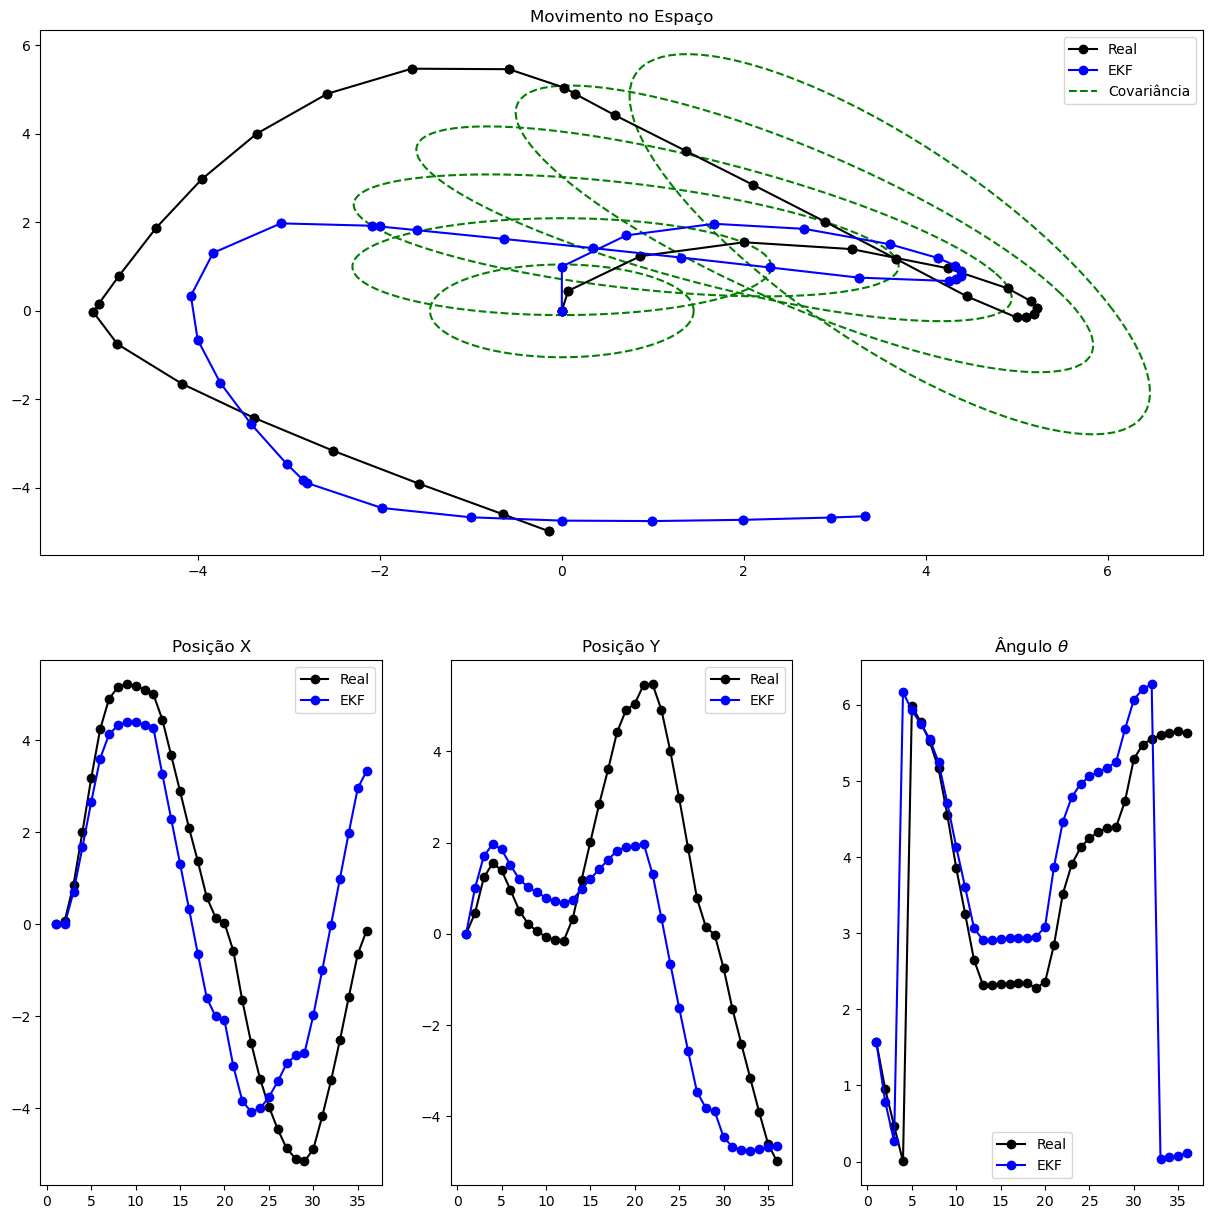

In [7]:
try:
    import sim
except:
    print ('"sim.py" could not be imported.')

sim.simxFinish(-1) # just in case, close all opened connections
clientID=sim.simxStart('127.0.0.1',19999,True,True,5000,5) # Connect to CoppeliaSim

if (clientID!=-1):
    print ('Connected to remote API server')
    
    # Características do Robô
    L = 0.331
    r = 0.09751
    maxv = 1.0
    maxw = np.deg2rad(45)
    
    # Inicialização do Robô Pioneer
    robotname = 'Pioneer_p3dx'
    returnCode, robotHandle = sim.simxGetObjectHandle(clientID, robotname, sim.simx_opmode_oneshot_wait)
    returnCode, roboPos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, roboOri = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, robotLeftMotorHandle  = sim.simxGetObjectHandle(clientID, robotname + '_leftMotor', sim.simx_opmode_oneshot_wait)
    returnCode, robotRightMotorHandle = sim.simxGetObjectHandle(clientID, robotname + '_rightMotor', sim.simx_opmode_oneshot_wait)
    
    # Inicialização do Extended Kalman Filter
    Xr = np.array([roboPos[0], roboPos[1], roboOri[2]]) # Robô Coppelia: [x, y, theta]
    Ur = np.array([0, 0])    # Atuação no Coppelia: [v, omega-]
    Xk = Xr # Estados EKF: [x, y, theta]
    Uk = np.array([0., 0.])    # Entradas: [v, omega-]
    Q = np.diag([.1,.1,.1]) # Erro de Modelagem
    Pk = np.eye(3)           # Matriz de Covariância
    
    # Definições de Tempo
    t = 0.0
    dt = 1
    
    tPlot = 10*dt
    dtPlot = 0

    # Atuação
    kr = .5
    kt = .5
    
    # Históricos
    histT = []
    histX = []
    histR = []
    histU = []
    
    time.sleep(2)
    startTime=time.time()
    
    fig = plt.figure(figsize=(15,15), dpi=100)
    ax0 = fig.add_subplot(211);
    ax0.plot(roboPos[0], roboPos[1], linestyle='-', marker='o', color='k');
    ax0.plot(Xk[0], Xk[1], linestyle='-', marker='o', color='b');
    
    
    path = np.array([[5,0], [0,5], [-5,0], [0,-5]])
    for posPath in path:
        qgoal = posPath
        
        rho = np.inf
        while rho>0.2:
    
            returnCode, roboPos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
            returnCode, roboOri = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
            
            # EKF
            # Predição
            Xk, Pk = predicao(Xk, Uk, Pk, Q, dt)
            
            if(dtPlot < 6):
                elipse = estEllipse(Pk[:2,:2], Xk[:2])
                ax0.plot(elipse[:,0], elipse[:,1], '--g')
            
            dx, dy = qgoal -roboPos[:2]
            rho = np.sqrt(dx**2 +dy**2)
            kr = abs(kr)
            alpha = normalizeAngle(-roboOri[2] + np.arctan2(dy,dx))
            
            # Alvo atrás
            if abs(alpha) > np.pi/2:
                kr = -abs(kr)
                alpha = normalizeAngle(alpha-np.pi)
            
            Uk[0] = kr*rho
            Uk[1] = kt*alpha
            
            # Limit v,w to +/- max
            Uk[0] = max(min(Uk[0], maxv), -maxv)
            Uk[1] = max(min(Uk[1], maxw), -maxw)
            
            wr = ((2.0*Uk[0]) + (Uk[1]*L))/(2.0*r)
            wl = ((2.0*Uk[0]) - (Uk[1]*L))/(2.0*r)

            t +=dt
            dtPlot += dt
            
            ax0.plot(roboPos[0], roboPos[1], linestyle='-', marker='o', color='k');
            ax0.plot(Xk[0], Xk[1], linestyle='-', marker='o', color='b');
    
            #Histórico
            histR.append([roboPos[0], roboPos[1], roboOri[2]%(2*math.pi)])
            histX.append([Xk[0], Xk[1], Xk[2]%(2*math.pi)])
            histU.append(Uk.tolist())
            histT.append(t)

            sim.simxSetJointTargetVelocity(clientID, robotRightMotorHandle, wr, sim.simx_opmode_oneshot_wait)
            sim.simxSetJointTargetVelocity(clientID, robotLeftMotorHandle, wl, sim.simx_opmode_oneshot_wait)

            time.sleep(dt)
    
    sim.simxSetJointTargetVelocity(clientID, robotRightMotorHandle, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(clientID, robotLeftMotorHandle, 0, sim.simx_opmode_oneshot_wait)

    # Now close the connection to CoppeliaSim:
    sim.simxFinish(clientID)
    
    ax0.plot(np.array(histR)[:,0], np.array(histR)[:,1], linestyle='-', marker='o', color='k');
    ax0.plot(np.array(histX)[:,0], np.array(histX)[:,1], linestyle='-', marker='o', color='b');
    ax0.legend(['Real', 'EKF', 'Covariância']);
    ax0.set_title("Movimento no Espaço");

    ax21 = fig.add_subplot(234);
    ax21.plot(histT, np.array(histR)[:,0], linestyle='-', marker='o', color='k');
    ax21.plot(histT, np.array(histX)[:,0], linestyle='-', marker='o', color='b');
    ax21.legend(['Real', 'EKF']);
    ax21.set_title("Posição X")

    ax22 = fig.add_subplot(235);
    ax22.plot(histT, np.array(histR)[:,1], linestyle='-', marker='o', color='k');
    ax22.plot(histT, np.array(histX)[:,1], linestyle='-', marker='o', color='b');
    ax22.legend(['Real', 'EKF']);
    ax22.set_title('Posição Y')

    ax23 = fig.add_subplot(236);
    ax23.plot(histT, np.array(histR)[:,2], linestyle='-', marker='o', color='k');
    ax23.plot(histT, np.array(histX)[:,2], linestyle='-', marker='o', color='b');
    ax23.legend(['Real', 'EKF']);
    ax23.set_title(r'Ângulo $\theta$')

    plt.show()

Os gráficos demonstram o desempenho o EKF frente ao movimento real do robô na simulação. Facilmente pode-se observar que, apesar de seguir um modelo matemático, erros e incertezas presentes na construção física do robô acabam impactando no movimento e estimações da localização do robô no ambiente. Pode-se exemplificar tais erros de modelagem como:
- Atrasos na atuação dos motores;
- Inércia do robô
- Deslizamento das rodas, entre outros.

No primeiro gráfico, é demonstrado também, a partir das linhas tracejadas em verde, o crescimento da incerteza do robô ao longo do trajeto percorrido. Uma vez que não foram feitas correções dos estados, a tendência é que esta incerteza cresça cada vez mais.

Conforme já esperado, o Filtro de Kalman Estendido possui uma etapa de correção para possibilitar um melhor desempenho nas estimações dos estados.

### Validação da Etapa de Correção do EKF

Para a correção, serão utilizadas as informações de localização do próprio robô, de modo que sejam lidas somente as informações de posição $(x,y)$ do robô, o que remete às matrizes de correção as seguintes características:

$$ h(x,k) = \begin{bmatrix} x \\ y \end{bmatrix} ~~~~~\rightarrow~~~~~ H_k = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \end{bmatrix} $$

In [5]:
def predicao (X, u, P, Q, dt):
    # X = [x, y, theta]
    fx = np.array([u[0]*math.cos(X[2]),
                   u[0]*math.sin(X[2]),
                   u[1]])
    # Jacobiana
    F = np.array([[1, 0, -math.sin(X[2])],
                  [0, 1,  math.cos(X[2])],
                  [0, 0,  1]])
    
    X = X +fx*dt # Xk = Xk-1 +fx
    P = F @ P @ F.T +Q
    
    return X, P
    
def correcao (X, P, hx, H, R, Z):
    S = H @ P @ H.T +R
    K = P @ H.T @ np.linalg.pinv(S)
    X = X +K @ (Z -hx)
    P = P -(K @ H @ P)
    
    return X, P

def estEllipse(P, pos):
    th = np.linspace(0, 2*math.pi, 100)
    y = np.array([np.cos(th), np.sin(th)])
    x = np.array(sqrtm(P[:2,:2]) @ y).T
    x[:,0] += pos[0]
    x[:,1] += pos[1]
    
    return x

# Normalize angle to the range [-pi,pi)
def normalizeAngle(angle):
    return np.mod(angle+np.pi, 2*np.pi) - np.pi

Connected to remote API server


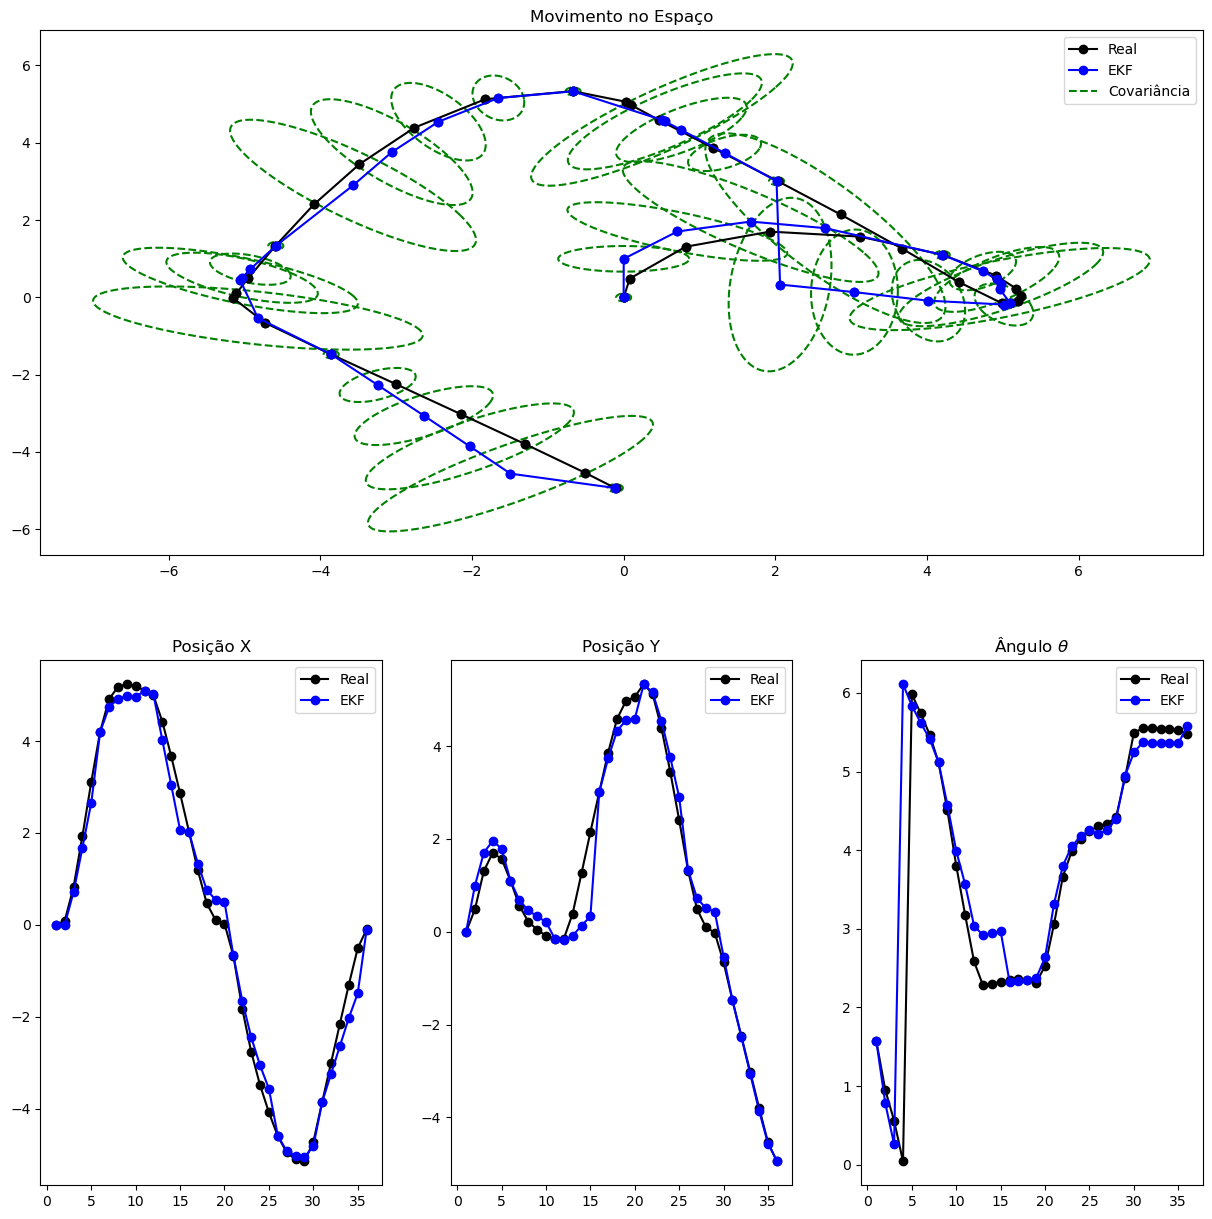

In [8]:
try:
    import sim
except:
    print ('"sim.py" could not be imported.')

sim.simxFinish(-1) # just in case, close all opened connections
clientID=sim.simxStart('127.0.0.1',19999,True,True,5000,5) # Connect to CoppeliaSim

if (clientID!=-1):
    print ('Connected to remote API server')
    
    # Características do Robô
    L = 0.331
    r = 0.09751
    maxv = 1.0
    maxw = np.deg2rad(45)
    
    # Inicialização do Robô Pioneer
    robotname = 'Pioneer_p3dx'
    returnCode, robotHandle = sim.simxGetObjectHandle(clientID, robotname, sim.simx_opmode_oneshot_wait)
    returnCode, roboPos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, roboOri = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, robotLeftMotorHandle  = sim.simxGetObjectHandle(clientID, robotname + '_leftMotor', sim.simx_opmode_oneshot_wait)
    returnCode, robotRightMotorHandle = sim.simxGetObjectHandle(clientID, robotname + '_rightMotor', sim.simx_opmode_oneshot_wait)
    
    # Inicialização do Extended Kalman Filter
    Xr = np.array([roboPos[0], roboPos[1], roboOri[2]]) # Robô Coppelia: [x, y, theta]
    Ur = np.array([0, 0])    # Atuação no Coppelia: [v, omega-]
    Xk = Xr # Estados EKF: [x, y, theta]
    Uk = np.array([0., 0.])    # Entradas: [v, omega-]
    Q = np.diag([.1,.1,.1]) # Erro de Modelagem
    R = np.diag([.01, .01]) # Erro de Medição
    Pk = np.eye(3)           # Matriz de Covariância
    
    # Definições de Tempo
    t = 0.0
    dt = 1
    
    tCorr = 5*dt
    dtCorr = np.inf

    # Atuação
    kr = .5
    kt = .5
    
    # Históricos
    histT = []
    histX = []
    histR = []
    histU = []
    
    time.sleep(2)
    startTime=time.time()
    
    fig = plt.figure(figsize=(15,15), dpi=100)
    ax0 = fig.add_subplot(211);
    ax0.plot(roboPos[0], roboPos[1], linestyle='-', marker='o', color='k');
    ax0.plot(Xk[0], Xk[1], linestyle='-', marker='o', color='b');
    
    
    path = np.array([[5,0], [0,5], [-5,0], [0,-5]])
    for posPath in path:
        qgoal = posPath
        
        rho = np.inf
        while rho>0.2:
    
            returnCode, roboPos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
            returnCode, roboOri = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
            
            # EKF
            # Predição
            Xk, Pk = predicao(Xk, Uk, Pk, Q, dt)
            
            if(dtCorr >= tCorr):
                dtCorr=0
                
                Zk = np.array([roboPos[0], roboPos[1]])
                
                hx = np.array([Xk[0], Xk[1]])
                Hk = np.array([[1, 0, 0], [0, 1, 0]])
                
                # Correção
                Xk, Pk = correcao(Xk, Pk, hx, Hk, R, Zk)
            
            dx, dy = qgoal -roboPos[:2]
            rho = np.sqrt(dx**2 +dy**2)
            kr = abs(kr)
            alpha = normalizeAngle(-roboOri[2] + np.arctan2(dy,dx))
            
            # Alvo atrás
            if abs(alpha) > np.pi/2:
                kr = -abs(kr)
                alpha = normalizeAngle(alpha-np.pi)
            
            Uk[0] = kr*rho
            Uk[1] = kt*alpha
            
            # Limit v,w to +/- max
            Uk[0] = max(min(Uk[0], maxv), -maxv)
            Uk[1] = max(min(Uk[1], maxw), -maxw)
            
            wr = ((2.0*Uk[0]) + (Uk[1]*L))/(2.0*r)
            wl = ((2.0*Uk[0]) - (Uk[1]*L))/(2.0*r)

            t +=dt
            dtPlot += dt
            dtCorr += dt
            
            elipse = estEllipse(Pk[:2,:2], Xk[:2])
            ax0.plot(elipse[:,0], elipse[:,1], '--g')
            ax0.plot(roboPos[0], roboPos[1], linestyle='-', marker='o', color='k');
            ax0.plot(Xk[0], Xk[1], linestyle='-', marker='o', color='b');
    
            #Histórico
            histR.append([roboPos[0], roboPos[1], roboOri[2]%(2*math.pi)])
            histX.append([Xk[0], Xk[1], Xk[2]%(2*math.pi)])
            histU.append(Uk.tolist())
            histT.append(t)

            sim.simxSetJointTargetVelocity(clientID, robotRightMotorHandle, wr, sim.simx_opmode_oneshot_wait)
            sim.simxSetJointTargetVelocity(clientID, robotLeftMotorHandle, wl, sim.simx_opmode_oneshot_wait)

            time.sleep(dt)
    
    sim.simxSetJointTargetVelocity(clientID, robotRightMotorHandle, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(clientID, robotLeftMotorHandle, 0, sim.simx_opmode_oneshot_wait)

    # Now close the connection to CoppeliaSim:
    sim.simxFinish(clientID)
    
    ax0.plot(np.array(histR)[:,0], np.array(histR)[:,1], linestyle='-', marker='o', color='k');
    ax0.plot(np.array(histX)[:,0], np.array(histX)[:,1], linestyle='-', marker='o', color='b');
    ax0.legend(['Real', 'EKF', 'Covariância']);
    ax0.set_title("Movimento no Espaço");

    ax21 = fig.add_subplot(234);
    ax21.plot(histT, np.array(histR)[:,0], linestyle='-', marker='o', color='k');
    ax21.plot(histT, np.array(histX)[:,0], linestyle='-', marker='o', color='b');
    ax21.legend(['Real', 'EKF']);
    ax21.set_title("Posição X")

    ax22 = fig.add_subplot(235);
    ax22.plot(histT, np.array(histR)[:,1], linestyle='-', marker='o', color='k');
    ax22.plot(histT, np.array(histX)[:,1], linestyle='-', marker='o', color='b');
    ax22.legend(['Real', 'EKF']);
    ax22.set_title('Posição Y')

    ax23 = fig.add_subplot(236);
    ax23.plot(histT, np.array(histR)[:,2], linestyle='-', marker='o', color='k');
    ax23.plot(histT, np.array(histX)[:,2], linestyle='-', marker='o', color='b');
    ax23.legend(['Real', 'EKF']);
    ax23.set_title(r'Ângulo $\theta$')

    plt.show()

Como resultado, observa-se que a correção, além de corrigir a estimação da localização do robô, também é responsável por reduzir a matriz $P_k$ que descreve as incertezas dos estados medidos. Uma vez que somente as informações de localização nos eixos $(x,y)$ foram corrigidas, observa-se que o ângulo $\theta$ , de forma indireta, também acabou sendo corrigido de forma indireta.

# Localização Indoor

Visto a efetividade do Filtro de Kalman Estendido, será implementado um sistema que busca localizar-se dentro de um ambiente *indoor* onde são disponibilizados apenas informações de potência de sinais *wireless*, como Wi-Fi. De modo prático, qualquer dispositivo é capaz de buscar por algumas dessas redes, sendo o sinal recebido referente à potência do sinal. Desta forma, é possível calcular a distância do robô ao gerador de sinal. A partir da detecção de várias redes e, conhecendo a localização de tais redes, é possível desenvolver o processo de triangulação e definir a localização, mesmo em ambientes *indoor*, como mostrado na imagem.

![Triangulação](Triangulação.jpg)

Na simulação a seguir, o robô deve se locomover até posições conhecidas do ambiente, sendo guiado apenas pelas informações coletadas de distâncias até as redes e um sensor de efeito Hall, responsável por auxiliar na correta  orientação do robô.

Na simulação, os sensores são disponíveis em tempos distintos, sendo o Filtro de Kalman atualizado de forma dinâmica, a partir das seguintes relações:

## Sensor de Efeito Hall

O sensor de efeito Hall tem uma taxa de atualização a cada 2 interações de previsão do EKF, além de ser modelado como segue:
- $\text{Medição}_{Hall} = \theta \pm 0.1$

Ele é introduzido ao EKF como:

$$ h_{Hall}(x,k) = \theta_k$$

$$ H_k = \begin{bmatrix} 0 & 0 & 1 \end{bmatrix}$$

$$ R_{Hall} = 0.01 $$


## Sinal *Wireless*

O sinal *wireless* é modelado de duas formas diferentes, considerando possíveis cenários durante a navegação:
1. O sensor percebe uma única rede, e precisa fazer a correção a partir das informações obtidas até então;
2. O sensor observa duas ou mais redes no espaço.

No primeiro caso, a proposta implementada faz com que o robô corrija sua localização baseada também nos parâmetros estimados, buscando a menor distância entre o local estimado e a circunferência de raio calculado pela potência do sinal.

![minDist](minDist.png)

No segundo caso, considerando a possibilidade de somente 2 redes serem encontradas, o mesmo processo descrito anteriormente foi implementado, mas, ao invés de verificar a menor distâncias às curvas, foi-se calculada a menor distância aos pontos de interseção. Novamente, essa informação é possível de ser calculada visto que a localização das fontes é conhecida.

Demais considerações sobre o sensor são identificadas a seguir:
- Frequência de atualização a cada 5Hz;
- Definição de uma distância máxima de propagação da rede;
- $\text{Distância} = \rho \pm 0.5$

Para o Filtro de Kalman, a introdução das informações do sinal *wireless* é incluído a partir dos seguintes dados:

$$ Z_{Power}(x,k) = \begin{bmatrix} x_{ref} +\rho_x \\ y_{ref} +\rho_y \end{bmatrix} $$

$$ h_{Power}(x,k) = \begin{bmatrix} x_k \\ y_k \end{bmatrix} $$

$$ H_k = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \end{bmatrix} $$

$$ R_k = e^{\frac{\rho}{10}} \cdot \begin{bmatrix} 0.1 & 0 & 0 \\ 0 & 0.1 & 0 \end{bmatrix} $$

Sendo o termo que multiplica a matriz de covariância do erro de medição, $R_k$, visa penalizar a certeza baseado na distância de propagação do sinal.

# Simulações

Nas simulações a seguir, são verificadas a efetividade da técnica proposta, sendo a primeira simulação desenvolvendo uma navegação com somente duas fontes de sinal *wireless*, de modo que existam regiões capazes de o movimento

## Simulação 01

In [4]:
def predicao (X, u, P, Q, dt):
    # X = [x, y, theta]
    fx = np.array([u[0]*math.cos(X[2]),
                   u[0]*math.sin(X[2]),
                   u[1]])
    # Jacobiana
    F = np.array([[1, 0, -math.sin(X[2])],
                  [0, 1,  math.cos(X[2])],
                  [0, 0,  1]])
    
    X = X +fx*dt # Xk = Xk-1 +fx
    P = F @ P @ F.T +Q
    
    return X, P
    
def correcao (X, P, hx, H, R, Z):
    S = H @ P @ H.T +R
    K = P @ H.T @ np.linalg.pinv(S)
    X = X +K @ (Z -hx)
    P = P -(K @ H @ P)
    
    return X, P

def estEllipse(P, pos):
    th = np.linspace(0, 2*math.pi, 100)
    y = np.array([np.cos(th), np.sin(th)])
    x = np.array(sqrtm(P[:2,:2]) @ y).T
    x[:,0] += pos[0]
    x[:,1] += pos[1]
    
    return x

# Normalize angle to the range [-pi,pi)
def normalizeAngle(angle):
    return np.mod(angle+np.pi, 2*np.pi) -np.pi

def pairComb(conjunto):
    combination = []
    index = 1
    for a in conjunto:
        for b in conjunto[index:]:
            combination.append([a, b])
        index +=1
    
    return combination

def netIntersecao(x0, y0, r0, x1, y1, r1):
    d=math.sqrt((x1-x0)**2 +(y1-y0)**2)
    
    # Sem interseção
    if d > r0 +r1:
        return None
    # Interno
    if d < abs(r0-r1):
        return None
    # Coincidentes
    if d == 0 and r0 == r1:
        return None
    else:
        a=(r0**2-r1**2+d**2)/(2*d)
        h=math.sqrt(r0**2-a**2)
        x2=x0+a*(x1-x0)/d
        y2=y0+a*(y1-y0)/d
        
        x3=x2+h*(y1-y0)/d
        y3=y2-h*(x1-x0)/d
        
        x4=x2-h*(y1-y0)/d
        y4=y2+h*(x1-x0)/d
        
        return (x3, y3, x4, y4)

Connected to remote API server


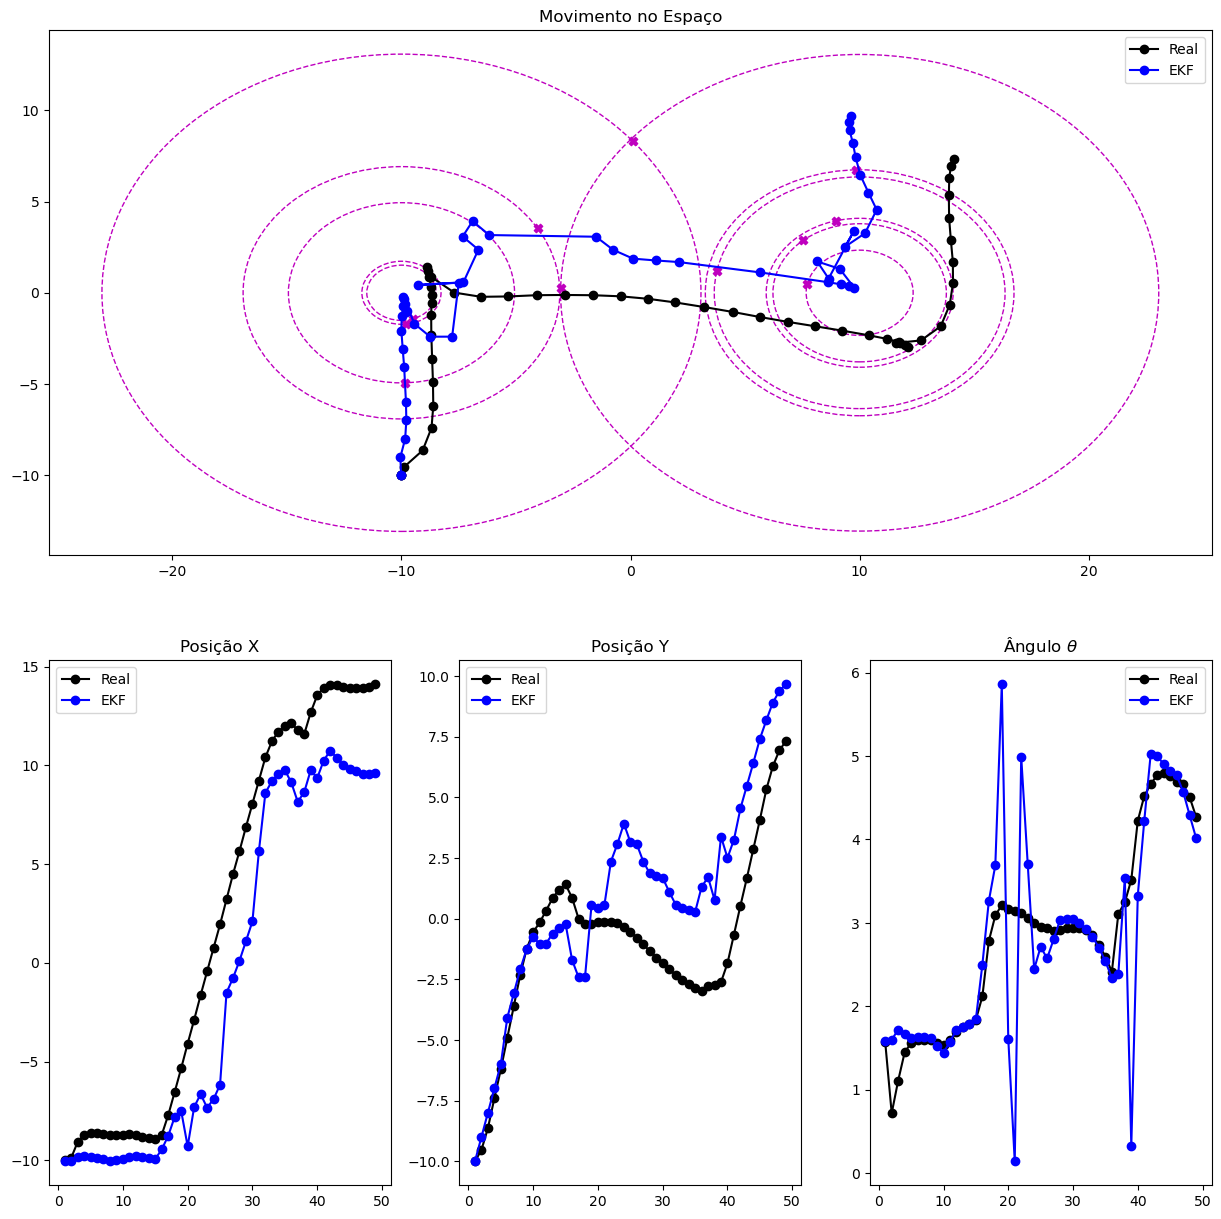

In [257]:
try:
    import sim
except:
    print ('"sim.py" could not be imported.')

sim.simxFinish(-1) # just in case, close all opened connections
clientID=sim.simxStart('127.0.0.1',19999,True,True,5000,5) # Connect to CoppeliaSim

if (clientID!=-1):
    print ('Connected to remote API server')
    
    # Características do Robô
    L = 0.331
    r = 0.09751
    maxv = 1.0
    maxw = np.deg2rad(45)
    
    # Inicialização do Robô Pioneer
    robotname = 'Pioneer_p3dx'
    returnCode, robotHandle = sim.simxGetObjectHandle(clientID, robotname, sim.simx_opmode_oneshot_wait)
    returnCode, roboPos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, roboOri = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, robotLeftMotorHandle  = sim.simxGetObjectHandle(clientID, robotname + '_leftMotor', sim.simx_opmode_oneshot_wait)
    returnCode, robotRightMotorHandle = sim.simxGetObjectHandle(clientID, robotname + '_rightMotor', sim.simx_opmode_oneshot_wait)
    
    # Descartar 1ª medição do Hokuyo
    returnCode, ranges = sim.simxGetStringSignal(clientID, 'scan ranges', sim.simx_opmode_streaming)
    time.sleep(0.1)
    
    # Inicialização do Extended Kalman Filter
    Xr = np.array([roboPos[0], roboPos[1], roboOri[2]]) # Robô Coppelia: [x, y, theta]
    Ur = np.array([0, 0])    # Atuação no Coppelia: [v, omega-]
    Xk = Xr # Estados EKF: [x, y, theta]
    Uk = np.array([0., 0.])    # Entradas: [v, omega-]
    Q = np.diag([.01,.01,.01]) # Erro de Modelagem
    R = np.diag([.01, .01]) # Erro de Medição
    Pk = np.eye(3)           # Matriz de Covariância
    fCorrecao = False
    
    # Definições de Tempo
    t = 0.0
    fTempo = 0
    dt = 1
    tPower = 5*dt   # 5Hz
    tComp = 2*dt   # 2Hz
    tLaser = 20*dt  # 20Hz
    dtPower = 0#np.inf
    dtComp = np.inf
    dtLaser = 0#np.inf
    
    # Parâmetros Sensor
    returnCode, Ref1 = sim.simxGetObjectHandle(clientID, 'Ref1', sim.simx_opmode_oneshot_wait)
    returnCode, Ref2 = sim.simxGetObjectHandle(clientID, 'Ref2', sim.simx_opmode_oneshot_wait)
    returnCode, ref1Pos = sim.simxGetObjectPosition(clientID, Ref1, -1, sim.simx_opmode_oneshot_wait)
    returnCode, ref2Pos = sim.simxGetObjectPosition(clientID, Ref2, -1, sim.simx_opmode_oneshot_wait)
    refPosConj = np.array([ref1Pos, ref2Pos])
    refPosComb = pairComb(refPosConj)
    
    rhoMax = 15
    erroPower = 0.5
    RPower = 0.1
    
    erroComp = 0.1
    RComp = .01
    
    erroLaser = np.array([math.sqrt(10e-3), 0.01]) # Por feixe
    RLaser = np.array([math.pow(10e-3,2), 0.1]) # [s²_rho, s²_theta]
    
    # Sensor Hokuyo
    laserMax = 5.0
    angleMin = (-120*(math.pi/180))
    angleMax = (120*(math.pi/180))
    dAngle = (240*math.pi)/(684*180)
    sensAngle = np.linspace(angleMin, angleMax, 684)
    
    # Atuação
    kr = 0.4
    kt = 0.5
    
    # Históricos
    histT = []
    histX = []
    histR = []
    histU = []
    histPower = []
    histComp = []
    histLaser = []
    
    time.sleep(2)
    startTime=time.time()
    
    plt.close()
    fig = plt.figure(figsize=(15,15), dpi=100)
    ax1 = fig.add_subplot(211);
    ax1.plot(roboPos[0], roboPos[1], linestyle='-', marker='o', color='k');
    ax1.plot(Xk[0], Xk[1], linestyle='-', marker='o', color='b');
    
    path = np.array([[-10,0], [10,0], [10,10]])
    for posPath in path:
        qgoal = posPath
        
        rho = np.inf
        startTime = int(time.strftime("%M"))
        while rho > .5 and fTempo == 0:
    
            returnCode, roboPos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
            returnCode, roboOri = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
            
            # Reset Sensores EKF
            if(dtPower >= tPower or dtComp >= tComp or dtLaser >= tLaser):
                # Distância Real
                rhoRef1 = np.sqrt((ref1Pos[0]-roboPos[0])**2 +(ref1Pos[1]-roboPos[1])**2) +erroPower*2*(random.random()-0.5)
                rhoRef2 = np.sqrt((ref2Pos[0]-roboPos[0])**2 +(ref2Pos[1]-roboPos[1])**2) +erroPower*2*(random.random()-0.5)
                rhoConj = np.array([rhoRef1, rhoRef2])
                
                rhoComb = pairComb(rhoConj)
                if(sum(rhoConj<rhoMax) or dtComp >= tComp):
                    fCorrecao = True
                    nRede = sum(rhoConj<rhoMax)
                    Zk = []
                    Rk = []
                    hk = []
                    Hk = []
            
            # Medição Potência do Sinal
            if(dtPower >= tPower):
                dtPower=0
                
                # Detecção 1 Rede
                for rho, refPos in zip(rhoConj, refPosConj):
                    if(rho<rhoMax):
                        # Distância Estimada
                        dxEst = Xk[0] -refPos[0]
                        dyEst = Xk[1] -refPos[1]
                        angEst = normalizeAngle(np.arctan2(dyEst,dxEst))
                        sensPower = np.array([refPos[0]+rho*np.cos(angEst), refPos[1]+rho*np.sin(angEst)])

                        Zk.append(sensPower[0])
                        Zk.append(sensPower[1])
                        Rk.append(RPower*math.exp(rho/10))
                        Rk.append(RPower*math.exp(rho/10))
                        hk.append(Xk[0])
                        hk.append(Xk[1])
                        Hk.append([1, 0, 0])
                        Hk.append([0, 1, 0])

                        histPower.append(sensPower)

                        ax1.scatter(sensPower[0],sensPower[1], marker='X', color='m');
                        circle = plt.Circle((refPos[0], refPos[1]), rho, linestyle='--', color='m', fill=False)
                        ax1.add_patch(circle)

                # Detecção 2 ou mais Rede
                if(nRede > 1):
                    for rho, refPos in zip(rhoComb, refPosComb):
                        if(rho[0]<rhoMax and rho[1]<rhoMax):
                            
                            Intersecoes = netIntersecao(refPos[0][0], refPos[0][1], rho[0], refPos[1][0], refPos[1][1], rho[1])
                            if(Intersecoes is not None):
                                x0, y0, x1, y1 = Intersecoes
                                
                                d1 = math.sqrt((Xk[0]-x0)**2 +(Xk[1]-y0)**2)
                                d2 = math.sqrt((Xk[0]-x1)**2 +(Xk[1]-y1)**2)
                                
                                if(d1 < d2):
                                    sensPower = np.array([x0, y0])
                                    Zk.append(x0)
                                    Zk.append(y0)
                                else:
                                    sensPower = np.array([x1, y1])
                                    Zk.append(x1)
                                    Zk.append(y1)
                                    
                                Rk.append(RPower)
                                Rk.append(RPower)
                                hk.append(Xk[0])
                                hk.append(Xk[1])
                                Hk.append([1, 0, 0])
                                Hk.append([0, 1, 0])
                                
                                ax1.scatter(sensPower[0],sensPower[1], marker='X', color='y');
                                circle = plt.Circle((refPos[0][0], refPos[0][1]), rho[0], linestyle='--', color='y', fill=False)
                                ax1.add_patch(circle)
                                circle = plt.Circle((refPos[1][0], refPos[1][1]), rho[1], linestyle='--', color='y', fill=False)
                                ax1.add_patch(circle)
                
            # Sensor Compasso
            if(dtComp >= tComp):
                dtComp=0
                
                sensComp = roboOri[2] +erroComp*2*(random.random()-0.5)

                Zk.append(sensComp)
                Rk.append(RComp)
                hk.append(Xk[2])
                Hk.append([0, 0, 1])
            
            # EKF
            # Predição
            Xk, Pk = predicao(Xk, Uk, Pk, Q, dt)
            
            # Correção
            if(fCorrecao == True):
                fCorrecao == False
                Z = np.asarray(Zk);
                R = np.diag(Rk);
                hx = np.asarray(hk);
                H = np.asarray(Hk);

                Xk, Pk = correcao(Xk, Pk, hx, H, R, Z)
            
            dx, dy = qgoal -Xk[:2]
            rho = np.sqrt(dx**2 +dy**2)
            kr = abs(kr)
            alpha = normalizeAngle(-roboOri[2] + np.arctan2(dy,dx))
            
            # Alvo atrás
            if abs(alpha) > np.pi/2:
                kr = -abs(kr)
                alpha = normalizeAngle(alpha-np.pi)
            
            Uk[0] = kr*rho
            Uk[1] = kt*alpha
            
            # Limit v,w to +/- max
            Uk[0] = max(min(Uk[0], maxv), -maxv)
            Uk[1] = max(min(Uk[1], maxw), -maxw)
            
            wr = ((2.0*Uk[0]) + (Uk[1]*L))/(2.0*r)
            wl = ((2.0*Uk[0]) - (Uk[1]*L))/(2.0*r)
            
            t +=dt
            dtPower += dt
            dtComp += dt
            
            #Histórico
            histR.append([roboPos[0], roboPos[1], roboOri[2]%(2*math.pi)])
            histX.append([Xk[0], Xk[1], Xk[2]%(2*math.pi)])
            histU.append(Uk.tolist())
            histT.append(t)

            sim.simxSetJointTargetVelocity(clientID, robotRightMotorHandle, wr, sim.simx_opmode_oneshot_wait)
            sim.simxSetJointTargetVelocity(clientID, robotLeftMotorHandle, wl, sim.simx_opmode_oneshot_wait)

            time.sleep(dt)
            
            nowTime = int(time.strftime("%M"))
            if int(nowTime) == (int(startTime) +2)%59:
                print("Não alcançou a Posição Final")
                fTempo = 1
    
    sim.simxSetJointTargetVelocity(clientID, robotRightMotorHandle, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(clientID, robotLeftMotorHandle, 0, sim.simx_opmode_oneshot_wait)

    # Now close the connection to CoppeliaSim:
    sim.simxFinish(clientID)
    
    ax1.plot(np.array(histR)[:,0], np.array(histR)[:,1], linestyle='-', marker='o', color='k');
    ax1.plot(np.array(histX)[:,0], np.array(histX)[:,1], linestyle='-', marker='o', color='b');
    ax1.legend(['Real', 'EKF']);
    ax1.set_title("Movimento no Espaço");
    
    ax21 = fig.add_subplot(234);
    ax21.plot(histT, np.array(histR)[:,0], linestyle='-', marker='o', color='k');
    ax21.plot(histT, np.array(histX)[:,0], linestyle='-', marker='o', color='b');
    ax21.legend(['Real', 'EKF']);
    ax21.set_title("Posição X")

    ax22 = fig.add_subplot(235);
    ax22.plot(histT, np.array(histR)[:,1], linestyle='-', marker='o', color='k');
    ax22.plot(histT, np.array(histX)[:,1], linestyle='-', marker='o', color='b');
    ax22.legend(['Real', 'EKF']);
    ax22.set_title('Posição Y')

    ax23 = fig.add_subplot(236);
    ax23.plot(histT, np.array(histR)[:,2], linestyle='-', marker='o', color='k');
    ax23.plot(histT, np.array(histX)[:,2], linestyle='-', marker='o', color='b');
    ax23.legend(['Real', 'EKF']);
    ax23.set_title(r'Ângulo $\theta$')
    
    plt.show()

Propondo um movimento simples, movendo-se em linha reta em grande parte do trajeto e alcançando o objeto final. Na imagem, são observadas as localizações por onde o robô passou, além das circunferências onde ocorreram as atualizações de localização do robô e a localização onde o EKF recebe para atualização. Além do movimento espacial, são apresentados também as diferenças entre os valores reais simulados e os estados do EKF.

Como era de se esperar, a baixa interseção entre as redes se mostra fraca para definir a localização correta do robô no espaço.

## Simulação 02

Na segunda simulação, o número de fontes de sinal é aumentado, de modo a serem observadas mais interseções. A localização das fontes de sinal são:
- Fonte 1: $(-10, 0)$
- Fonte 2: $(10, 0)$
- Fonte 3: $(0, -10)$
- Fonte 4: $(0, 10)$

Connected to remote API server


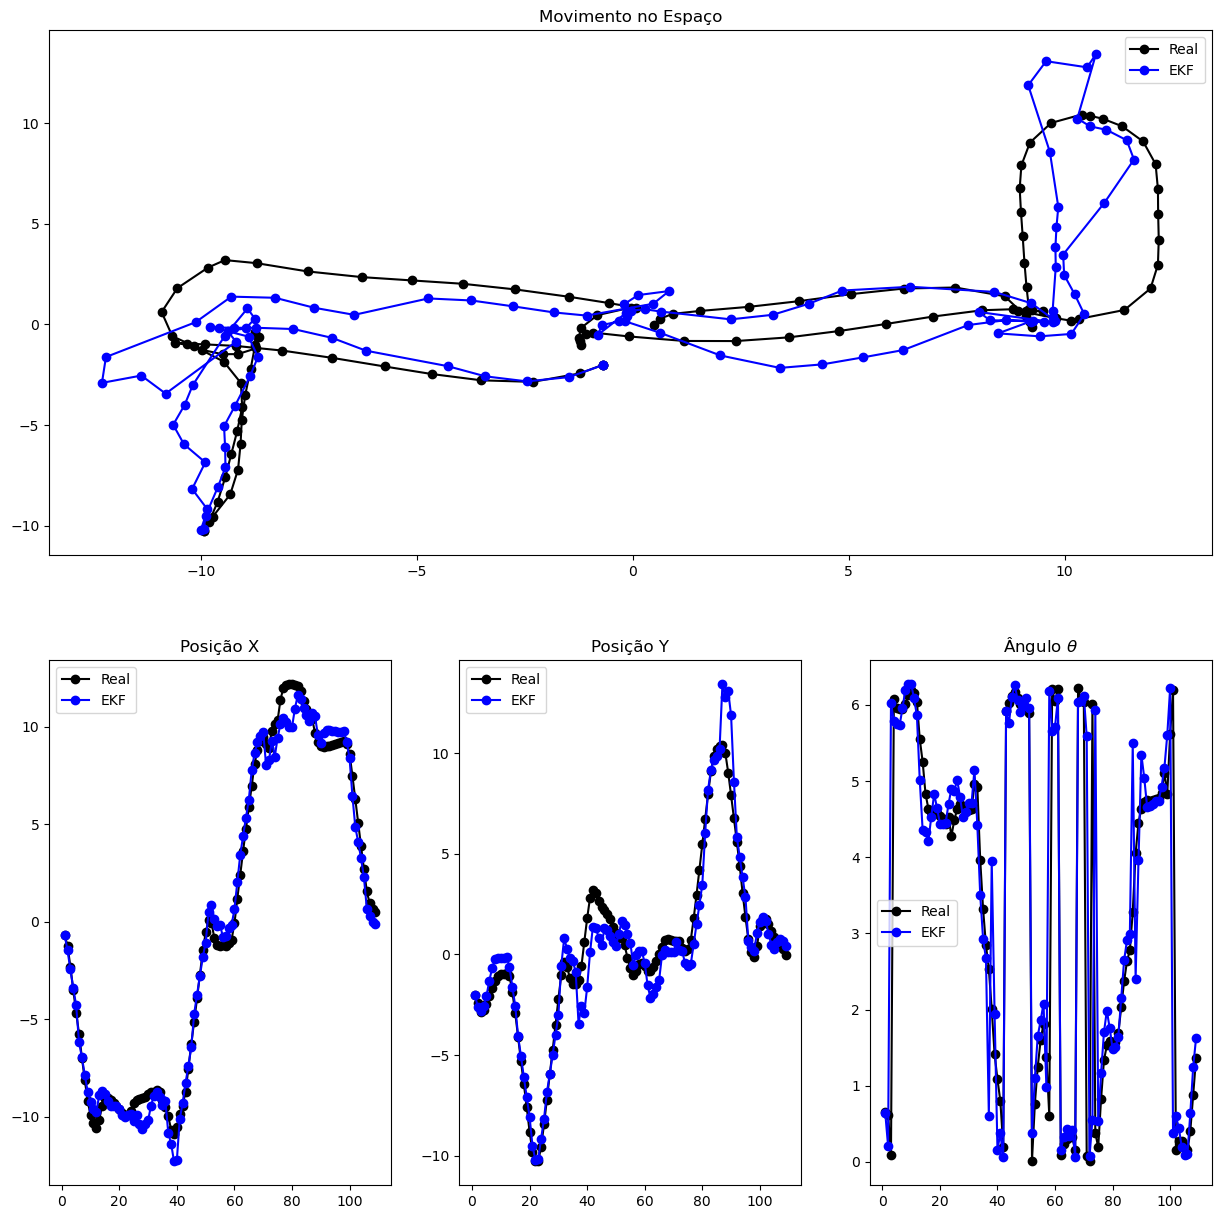

In [231]:
try:
    import sim
except:
    print ('"sim.py" could not be imported.')

sim.simxFinish(-1) # just in case, close all opened connections
clientID=sim.simxStart('127.0.0.1',19999,True,True,5000,5) # Connect to CoppeliaSim

if (clientID!=-1):
    print ('Connected to remote API server')
    
    # Características do Robô
    L = 0.331
    r = 0.09751
    maxv = 1.0
    maxw = np.deg2rad(45)
    
    # Inicialização do Robô Pioneer
    robotname = 'Pioneer_p3dx'
    returnCode, robotHandle = sim.simxGetObjectHandle(clientID, robotname, sim.simx_opmode_oneshot_wait)
    returnCode, roboPos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, roboOri = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, robotLeftMotorHandle  = sim.simxGetObjectHandle(clientID, robotname + '_leftMotor', sim.simx_opmode_oneshot_wait)
    returnCode, robotRightMotorHandle = sim.simxGetObjectHandle(clientID, robotname + '_rightMotor', sim.simx_opmode_oneshot_wait)
    
    # Descartar 1ª medição do Hokuyo
    returnCode, ranges = sim.simxGetStringSignal(clientID, 'scan ranges', sim.simx_opmode_streaming)
    time.sleep(0.1)
    
    # Inicialização do Extended Kalman Filter
    Xr = np.array([roboPos[0], roboPos[1], roboOri[2]]) # Robô Coppelia: [x, y, theta]
    Ur = np.array([0, 0])    # Atuação no Coppelia: [v, omega-]
    Xk = Xr # Estados EKF: [x, y, theta]
    Uk = np.array([0., 0.])    # Entradas: [v, omega-]
    Q = np.diag([.01,.01,.01]) # Erro de Modelagem
    R = np.diag([.01, .01]) # Erro de Medição
    Pk = np.eye(3)           # Matriz de Covariância
    fCorrecao = False
    
    # Definições de Tempo
    t = 0.0
    fTempo = 0
    dt = 1
    tPower = 5*dt   # 5Hz
    tComp = 2*dt   # 2Hz
    tLaser = 20*dt  # 20Hz
    dtPower = 0#np.inf
    dtComp = np.inf
    dtLaser = 0#np.inf
    
    # Parâmetros Sensor
    returnCode, Ref1 = sim.simxGetObjectHandle(clientID, 'Ref1', sim.simx_opmode_oneshot_wait)
    returnCode, Ref2 = sim.simxGetObjectHandle(clientID, 'Ref2', sim.simx_opmode_oneshot_wait)
    returnCode, Ref3 = sim.simxGetObjectHandle(clientID, 'Ref3', sim.simx_opmode_oneshot_wait)
    returnCode, Ref4 = sim.simxGetObjectHandle(clientID, 'Ref4', sim.simx_opmode_oneshot_wait)
    returnCode, ref1Pos = sim.simxGetObjectPosition(clientID, Ref1, -1, sim.simx_opmode_oneshot_wait)
    returnCode, ref2Pos = sim.simxGetObjectPosition(clientID, Ref2, -1, sim.simx_opmode_oneshot_wait)
    returnCode, ref3Pos = sim.simxGetObjectPosition(clientID, Ref3, -1, sim.simx_opmode_oneshot_wait)
    returnCode, ref4Pos = sim.simxGetObjectPosition(clientID, Ref4, -1, sim.simx_opmode_oneshot_wait)
    refPosConj = np.array([ref1Pos, ref2Pos, ref3Pos, ref4Pos])
    refPosComb = pairComb(refPosConj)
    
    rhoMax = 15
    erroPower = 0.5
    RPower = 0.1
    
    erroComp = 0.1
    RComp = .01
    
    erroLaser = np.array([math.sqrt(10e-3), 0.01]) # Por feixe
    RLaser = np.array([math.pow(10e-3,2), 0.1]) # [s²_rho, s²_theta]
    
    # Sensor Hokuyo
    laserMax = 5.0
    angleMin = (-120*(math.pi/180))
    angleMax = (120*(math.pi/180))
    dAngle = (240*math.pi)/(684*180)
    sensAngle = np.linspace(angleMin, angleMax, 684)
    
    # Atuação
    kr = 0.4
    kt = 0.5
    
    # Históricos
    histT = []
    histX = []
    histR = []
    histU = []
    histPower = []
    histComp = []
    histLaser = []
    
    time.sleep(2)
    startTime=time.time()
    
    plt.close()
    fig = plt.figure(figsize=(15,15), dpi=100)
    ax1 = fig.add_subplot(211);
    ax1.plot(roboPos[0], roboPos[1], linestyle='-', marker='o', color='k');
    ax1.plot(Xk[0], Xk[1], linestyle='-', marker='o', color='b');
    
    path = np.array([[-10,0], [-10,-10],
                     [-10,0], [0,0],
                     [10,0], [10,10],
                     [10,0], [0,0]])
    
    for posPath in path:
        qgoal = posPath
        
        rho = np.inf
        startTime = int(time.strftime("%M"))
        while rho > .5 and fTempo == 0:
    
            returnCode, roboPos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
            returnCode, roboOri = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
            
            # Reset Sensores EKF
            if(dtPower >= tPower or dtComp >= tComp or dtLaser >= tLaser):
                # Distância Real
                rhoRef1 = np.sqrt((ref1Pos[0]-roboPos[0])**2 +(ref1Pos[1]-roboPos[1])**2) +erroPower*2*(random.random()-0.5)
                rhoRef2 = np.sqrt((ref2Pos[0]-roboPos[0])**2 +(ref2Pos[1]-roboPos[1])**2) +erroPower*2*(random.random()-0.5)
                rhoRef3 = np.sqrt((ref3Pos[0]-roboPos[0])**2 +(ref3Pos[1]-roboPos[1])**2) +erroPower*2*(random.random()-0.5)
                rhoRef4 = np.sqrt((ref4Pos[0]-roboPos[0])**2 +(ref4Pos[1]-roboPos[1])**2) +erroPower*2*(random.random()-0.5)
                rhoConj = np.array([rhoRef1, rhoRef2, rhoRef3, rhoRef4])
                
                rhoComb = pairComb(rhoConj)
                if(sum(rhoConj<rhoMax) or dtComp >= tComp):
                    fCorrecao = True
                    nRede = sum(rhoConj<rhoMax)
                    Zk = []
                    Rk = []
                    hk = []
                    Hk = []
            
            # Medição Potência do Sinal
            if(dtPower >= tPower):
                dtPower=0
                
                # Detecção 1 Rede
                for rho, refPos in zip(rhoConj, refPosConj):
                    if(rho<rhoMax):
                        # Distância Estimada
                        dxEst = Xk[0] -refPos[0]
                        dyEst = Xk[1] -refPos[1]
                        angEst = normalizeAngle(np.arctan2(dyEst,dxEst))
                        sensPower = np.array([refPos[0]+rho*np.cos(angEst), refPos[1]+rho*np.sin(angEst)])

                        Zk.append(sensPower[0])
                        Zk.append(sensPower[1])
                        Rk.append(RPower*math.exp(rho/10))
                        Rk.append(RPower*math.exp(rho/10))
                        hk.append(Xk[0])
                        hk.append(Xk[1])
                        Hk.append([1, 0, 0])
                        Hk.append([0, 1, 0])

                        histPower.append(sensPower)
                        
                        #ax1.scatter(sensPower[0],sensPower[1], marker='X', color='m');
                        #circle = plt.Circle((refPos[0], refPos[1]), rho, linestyle='--', color='m', fill=False)
                        #ax1.add_patch(circle)

                # Detecção 2 ou mais Rede
                if(nRede > 1):
                    for rho, refPos in zip(rhoComb, refPosComb):
                        if(rho[0]<rhoMax and rho[1]<rhoMax):
                            
                            Intersecoes = netIntersecao(refPos[0][0], refPos[0][1], rho[0], refPos[1][0], refPos[1][1], rho[1])
                            if(Intersecoes is not None):
                                x0, y0, x1, y1 = Intersecoes
                                
                                d1 = math.sqrt((Xk[0]-x0)**2 +(Xk[1]-y0)**2)
                                d2 = math.sqrt((Xk[0]-x1)**2 +(Xk[1]-y1)**2)
                                
                                if(d1 < d2):
                                    sensPower = np.array([x0, y0])
                                    Zk.append(x0)
                                    Zk.append(y0)
                                else:
                                    sensPower = np.array([x1, y1])
                                    Zk.append(x1)
                                    Zk.append(y1)
                                    
                                Rk.append(RPower)
                                Rk.append(RPower)
                                hk.append(Xk[0])
                                hk.append(Xk[1])
                                Hk.append([1, 0, 0])
                                Hk.append([0, 1, 0])
                                
                                #ax1.scatter(sensPower[0],sensPower[1], marker='X', color='y');
                                #circle = plt.Circle((refPos[0][0], refPos[0][1]), rho[0], linestyle='--', color='y', fill=False)
                                #ax1.add_patch(circle)
                                #circle = plt.Circle((refPos[1][0], refPos[1][1]), rho[1], linestyle='--', color='y', fill=False)
                                #ax1.add_patch(circle)
                
            # Sensor Compasso
            if(dtComp >= tComp):
                dtComp=0
                
                sensComp = roboOri[2] +erroComp*2*(random.random()-0.5)

                Zk.append(sensComp)
                Rk.append(RComp)
                hk.append(Xk[2])
                Hk.append([0, 0, 1])
            
            # EKF
            # Predição
            Xk, Pk = predicao(Xk, Uk, Pk, Q, dt)
            
            # Correção
            if(fCorrecao == True):
                fCorrecao == False
                Z = np.asarray(Zk);
                R = np.diag(Rk);
                hx = np.asarray(hk);
                H = np.asarray(Hk);

                Xk, Pk = correcao(Xk, Pk, hx, H, R, Z)
            
            dx, dy = qgoal -Xk[:2]
            rho = np.sqrt(dx**2 +dy**2)
            kr = abs(kr)
            alpha = normalizeAngle(-roboOri[2] + np.arctan2(dy,dx))
            
            # Alvo atrás
            if abs(alpha) > np.pi/2:
                kr = -abs(kr)
                alpha = normalizeAngle(alpha-np.pi)
            
            Uk[0] = kr*rho
            Uk[1] = kt*alpha
            
            # Limit v,w to +/- max
            Uk[0] = max(min(Uk[0], maxv), -maxv)
            Uk[1] = max(min(Uk[1], maxw), -maxw)
            
            wr = ((2.0*Uk[0]) + (Uk[1]*L))/(2.0*r)
            wl = ((2.0*Uk[0]) - (Uk[1]*L))/(2.0*r)
            
            t +=dt
            dtPower += dt
            dtComp += dt
            
            #elipse = estEllipse(Pk[:2,:2], Xk[:2])
            #ax1.plot(elipse[:,0], elipse[:,1], '--g')
            #ax1.plot(roboPos[0], roboPos[1], linestyle='-', marker='o', color='k');
            #ax1.plot(Xk[0], Xk[1], linestyle='-', marker='o', color='b');
    
            #Histórico
            histR.append([roboPos[0], roboPos[1], roboOri[2]%(2*math.pi)])
            histX.append([Xk[0], Xk[1], Xk[2]%(2*math.pi)])
            histU.append(Uk.tolist())
            histT.append(t)

            sim.simxSetJointTargetVelocity(clientID, robotRightMotorHandle, wr, sim.simx_opmode_oneshot_wait)
            sim.simxSetJointTargetVelocity(clientID, robotLeftMotorHandle, wl, sim.simx_opmode_oneshot_wait)

            time.sleep(dt)
            
            nowTime = int(time.strftime("%M"))
            if int(nowTime) == (int(startTime) +2)%59:
                print("Não alcançou a Posição Final")
                fTempo = 1
    
    sim.simxSetJointTargetVelocity(clientID, robotRightMotorHandle, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(clientID, robotLeftMotorHandle, 0, sim.simx_opmode_oneshot_wait)

    # Now close the connection to CoppeliaSim:
    sim.simxFinish(clientID)
    
    ax1.plot(np.array(histR)[:,0], np.array(histR)[:,1], linestyle='-', marker='o', color='k');
    ax1.plot(np.array(histX)[:,0], np.array(histX)[:,1], linestyle='-', marker='o', color='b');
    ax1.legend(['Real', 'EKF']);
    ax1.set_title("Movimento no Espaço");
    
    ax21 = fig.add_subplot(234);
    ax21.plot(histT, np.array(histR)[:,0], linestyle='-', marker='o', color='k');
    ax21.plot(histT, np.array(histX)[:,0], linestyle='-', marker='o', color='b');
    ax21.legend(['Real', 'EKF']);
    ax21.set_title("Posição X")

    ax22 = fig.add_subplot(235);
    ax22.plot(histT, np.array(histR)[:,1], linestyle='-', marker='o', color='k');
    ax22.plot(histT, np.array(histX)[:,1], linestyle='-', marker='o', color='b');
    ax22.legend(['Real', 'EKF']);
    ax22.set_title('Posição Y')

    ax23 = fig.add_subplot(236);
    ax23.plot(histT, np.array(histR)[:,2], linestyle='-', marker='o', color='k');
    ax23.plot(histT, np.array(histX)[:,2], linestyle='-', marker='o', color='b');
    ax23.legend(['Real', 'EKF']);
    ax23.set_title(r'Ângulo $\theta$')
    
    plt.show()

A simulação propôs ao robô alcançar os mesmos pontos da simulação anterior, mas de forma que fosse necessário que o robô passasse duas vezes pela mesma localidade. Para tornar a visualização mais limpa, não foram apresentadas as correções ou o sinal de potência lido pelo robô.

Como resultado, observa-se que o robô foi capaz de se locomover ao longo do trajeto, sendo que os maiores erros são, novamente, observado em regiões onde uma única fonte de sinal é captada pelo robô.

# Aplicação Prática

Conforme observado, a localização proposta apresentou resultados bons resultados, sendo capaz de estimar e fazer as devidas correções na localização do robô durante a navegação e com erros relativamente pequenos. Diante de uma navegação efetiva, pode-se propor uma evolução do sistema para aplicações como o SLAM, onde se desenvolve o mapeamento e a localização durante a navegação.

A simulação a seguir foi desenvolvida fazendo que o robô percorresse localizações sabidamente livres, sendo armezenadas as informações do laser Hokuyo acoplado ao robô. Todo o movimento e alocação dos obstáculos são realizadas a partir das informações desenvolvidas pelo Filtro de Kalman Estendido.

Connected to remote API server


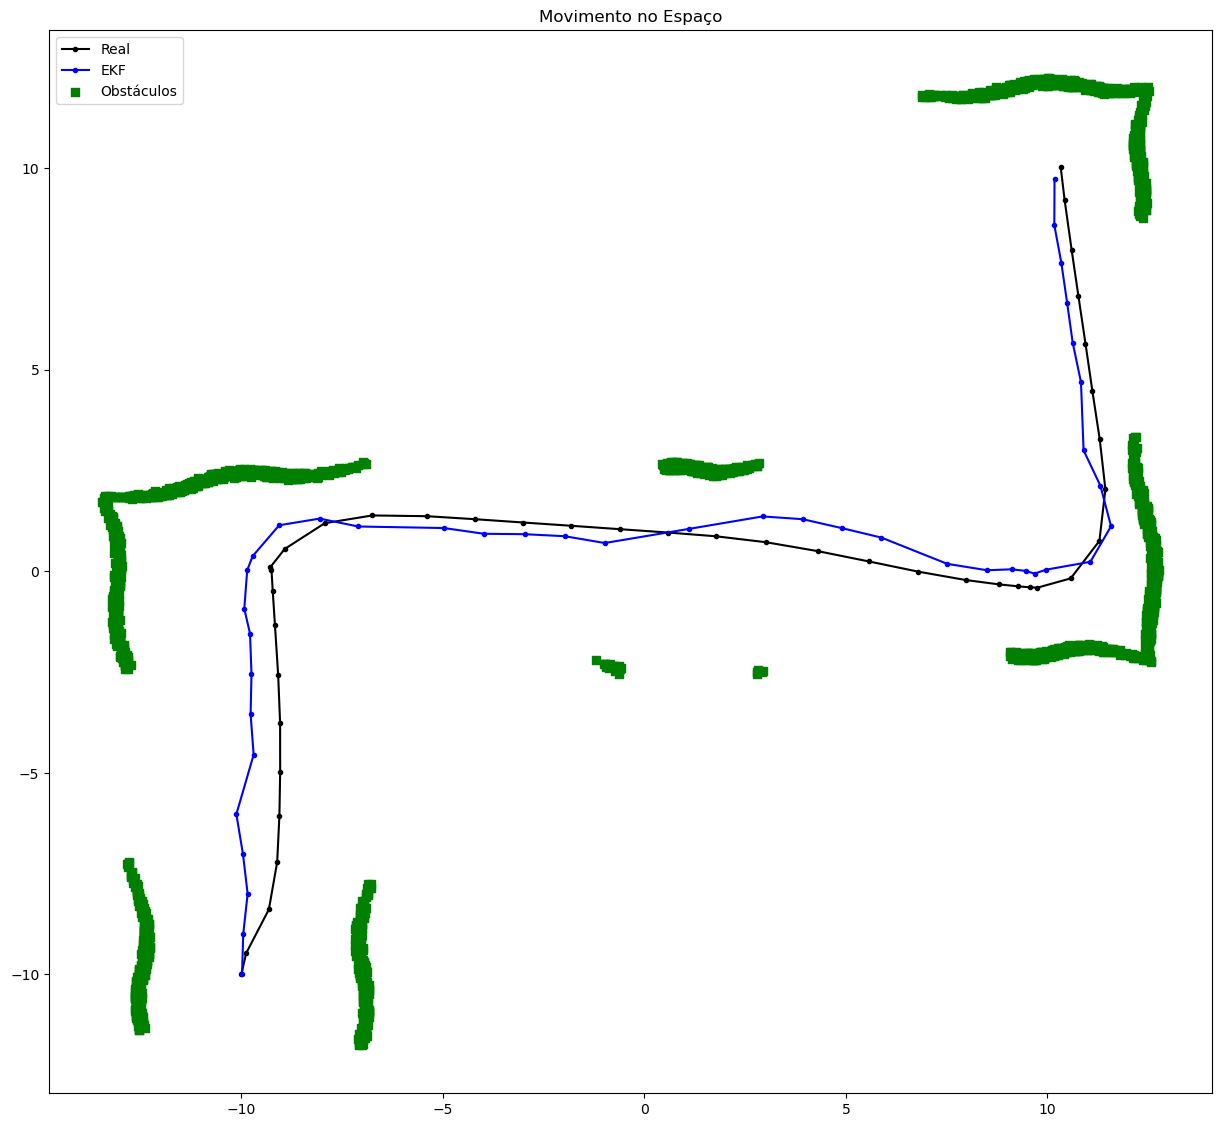

In [21]:
try:
    import sim
except:
    print ('"sim.py" could not be imported.')

sim.simxFinish(-1) # just in case, close all opened connections
clientID=sim.simxStart('127.0.0.1',19999,True,True,5000,5) # Connect to CoppeliaSim

if (clientID!=-1):
    print ('Connected to remote API server')
    
    # Características do Robô
    L = 0.331
    r = 0.09751
    maxv = 1.0
    maxw = np.deg2rad(45)
    
    # Inicialização do Robô Pioneer
    robotname = 'Pioneer_p3dx'
    returnCode, robotHandle = sim.simxGetObjectHandle(clientID, robotname, sim.simx_opmode_oneshot_wait)
    returnCode, roboPos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, roboOri = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, robotLeftMotorHandle  = sim.simxGetObjectHandle(clientID, robotname + '_leftMotor', sim.simx_opmode_oneshot_wait)
    returnCode, robotRightMotorHandle = sim.simxGetObjectHandle(clientID, robotname + '_rightMotor', sim.simx_opmode_oneshot_wait)
    
    # Descartar 1ª medição do Hokuyo
    returnCode, ranges = sim.simxGetStringSignal(clientID, 'scan ranges', sim.simx_opmode_streaming)
    time.sleep(0.1)
    
    # Inicialização do Extended Kalman Filter
    Xr = np.array([roboPos[0], roboPos[1], roboOri[2]]) # Robô Coppelia: [x, y, theta]
    Ur = np.array([0, 0])    # Atuação no Coppelia: [v, omega-]
    Xk = Xr # Estados EKF: [x, y, theta]
    Uk = np.array([0., 0.])    # Entradas: [v, omega-]
    Q = np.diag([.01,.01,.01]) # Erro de Modelagem
    R = np.diag([.01, .01]) # Erro de Medição
    Pk = np.eye(3)           # Matriz de Covariância
    fCorrecao = False
    
    # Definições de Tempo
    t = 0.0
    fTempo = 0
    dt = 1
    tPower = 5*dt   # 5Hz
    tComp = 2*dt   # 2Hz
    tLaser = 10*dt  # 10Hz
    dtPower = 0#np.inf
    dtComp = np.inf
    dtLaser = np.inf
    
    # Parâmetros Sensor
    returnCode, Ref1 = sim.simxGetObjectHandle(clientID, 'Ref1', sim.simx_opmode_oneshot_wait)
    returnCode, Ref2 = sim.simxGetObjectHandle(clientID, 'Ref2', sim.simx_opmode_oneshot_wait)
    returnCode, Ref3 = sim.simxGetObjectHandle(clientID, 'Ref3', sim.simx_opmode_oneshot_wait)
    returnCode, Ref4 = sim.simxGetObjectHandle(clientID, 'Ref4', sim.simx_opmode_oneshot_wait)
    returnCode, ref1Pos = sim.simxGetObjectPosition(clientID, Ref1, -1, sim.simx_opmode_oneshot_wait)
    returnCode, ref2Pos = sim.simxGetObjectPosition(clientID, Ref2, -1, sim.simx_opmode_oneshot_wait)
    returnCode, ref3Pos = sim.simxGetObjectPosition(clientID, Ref3, -1, sim.simx_opmode_oneshot_wait)
    returnCode, ref4Pos = sim.simxGetObjectPosition(clientID, Ref4, -1, sim.simx_opmode_oneshot_wait)
    refPosConj = np.array([ref1Pos, ref2Pos, ref3Pos, ref4Pos])
    refPosComb = pairComb(refPosConj)
    
    rhoMax = 15
    erroPower = 0.5
    RPower = 0.1
    
    erroComp = 0.1
    RComp = .01
    
    erroLaser = math.sqrt(10e-3) # Por feixe
    RLaser = np.array([math.pow(10e-3,2), 0.1]) # [s²_rho, s²_theta]
    
    # Sensor Hokuyo
    laserMax = 5.0
    angleMin = (-120*(math.pi/180))
    angleMax = (120*(math.pi/180))
    dAngle = (240*math.pi)/(684*180)
    sensAngle = np.linspace(angleMin, angleMax, 684)
    
    obsX = []
    obsY = []
    
    # Atuação
    kr = 0.4
    kt = 0.5
    
    # Históricos
    histT = []
    histX = []
    histR = []
    histU = []
    histPower = []
    histComp = []
    histLaser = []
    
    time.sleep(2)
    startTime=time.time()
    
    plt.close()
    fig = plt.figure(figsize=(15,15), dpi=100)
    ax1 = fig.add_subplot(111, aspect='equal');
    
    path = np.array([[-10,0], [10,0], [10,10]])
    for posPath in path:
        qgoal = posPath
        
        rho = np.inf
        startTime = int(time.strftime("%M"))
        while rho > .5 and fTempo == 0:
            returnCode, roboPos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
            returnCode, roboOri = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
            returnCode, roboHokuyo = sim.simxGetStringSignal(clientID, 'scan ranges', sim.simx_opmode_buffer)
            sensRange = sim.simxUnpackFloats(roboHokuyo)
        
            # Reset Sensores EKF
            if(dtPower >= tPower or dtComp >= tComp):
                # Distância Real + Erro
                rhoRef1 = np.sqrt((ref1Pos[0]-roboPos[0])**2 +(ref1Pos[1]-roboPos[1])**2) +erroPower*2*(random.random()-0.5)
                rhoRef2 = np.sqrt((ref2Pos[0]-roboPos[0])**2 +(ref2Pos[1]-roboPos[1])**2) +erroPower*2*(random.random()-0.5)
                rhoRef3 = np.sqrt((ref3Pos[0]-roboPos[0])**2 +(ref3Pos[1]-roboPos[1])**2) +erroPower*2*(random.random()-0.5)
                rhoRef4 = np.sqrt((ref4Pos[0]-roboPos[0])**2 +(ref4Pos[1]-roboPos[1])**2) +erroPower*2*(random.random()-0.5)
                rhoConj = np.array([rhoRef1, rhoRef2, rhoRef3, rhoRef4])
                
                rhoComb = pairComb(rhoConj)
                if(sum(rhoConj<rhoMax) or dtComp >= tComp):
                    fCorrecao = True
                    nRede = sum(rhoConj<rhoMax)
                    Zk = []
                    Rk = []
                    hk = []
                    Hk = []
            
            # Medição Potência do Sinal
            if(dtPower >= tPower):
                dtPower=0
                
                # Detecção 1 Rede
                for rho, refPos in zip(rhoConj, refPosConj):
                    if(rho<rhoMax):
                        # Distância Estimada
                        dxEst = Xk[0] -refPos[0]
                        dyEst = Xk[1] -refPos[1]
                        angEst = normalizeAngle(np.arctan2(dyEst,dxEst))
                        sensPower = np.array([refPos[0]+rho*np.cos(angEst), refPos[1]+rho*np.sin(angEst)])

                        Zk.append(sensPower[0])
                        Zk.append(sensPower[1])
                        Rk.append(RPower*math.exp(rho/10))
                        Rk.append(RPower*math.exp(rho/10))
                        hk.append(Xk[0])
                        hk.append(Xk[1])
                        Hk.append([1, 0, 0])
                        Hk.append([0, 1, 0])

                        histPower.append(sensPower)
                        
                        #ax1.scatter(sensPower[0],sensPower[1], marker='X', color='m');
                        #circle = plt.Circle((refPos[0], refPos[1]), rho, linestyle='--', color='m', fill=False)
                        #ax1.add_patch(circle)

                # Detecção 2 ou mais Rede
                if(nRede > 1):
                    for rho, refPos in zip(rhoComb, refPosComb):
                        if(rho[0]<rhoMax and rho[1]<rhoMax):
                            
                            Intersecoes = netIntersecao(refPos[0][0], refPos[0][1], rho[0], refPos[1][0], refPos[1][1], rho[1])
                            if(Intersecoes is not None):
                                x0, y0, x1, y1 = Intersecoes
                                
                                d1 = math.sqrt((Xk[0]-x0)**2 +(Xk[1]-y0)**2)
                                d2 = math.sqrt((Xk[0]-x1)**2 +(Xk[1]-y1)**2)
                                
                                if(d1 < d2):
                                    sensPower = np.array([x0, y0])
                                    Zk.append(x0)
                                    Zk.append(y0)
                                else:
                                    sensPower = np.array([x1, y1])
                                    Zk.append(x1)
                                    Zk.append(y1)
                                    
                                Rk.append(RPower)
                                Rk.append(RPower)
                                hk.append(Xk[0])
                                hk.append(Xk[1])
                                Hk.append([1, 0, 0])
                                Hk.append([0, 1, 0])
                                
                                #ax1.scatter(sensPower[0],sensPower[1], marker='X', color='y');
                                #circle = plt.Circle((refPos[0][0], refPos[0][1]), rho[0], linestyle='--', color='y', fill=False)
                                #ax1.add_patch(circle)
                                #circle = plt.Circle((refPos[1][0], refPos[1][1]), rho[1], linestyle='--', color='y', fill=False)
                                #ax1.add_patch(circle)
                
            # Sensor Compasso
            if(dtComp >= tComp):
                dtComp=0
                
                sensComp = roboOri[2] +erroComp*2*(random.random()-0.5)

                Zk.append(sensComp)
                Rk.append(RComp)
                hk.append(Xk[2])
                Hk.append([0, 0, 1])
            
            # EKF
            # Predição
            Xk, Pk = predicao(Xk, Uk, Pk, Q, dt)
            
            # Correção
            if(fCorrecao == True):
                fCorrecao == False
                Z = np.asarray(Zk);
                R = np.diag(Rk);
                hx = np.asarray(hk);
                H = np.asarray(Hk);

                Xk, Pk = correcao(Xk, Pk, hx, H, R, Z)
            
            # Sensor Hokuyo
            if(dtLaser >= tLaser):
                dtLaser=0
                for angle, dist in zip(sensAngle, sensRange):
                    dist = dist +erroLaser*2*(random.random()-0.5)
                    if(dist<laserMax-1):
                        globalAngle = normalizeAngle(Xk[2] +angle)
                        obsX.append(Xk[0] +dist*math.cos(globalAngle))
                        obsY.append(Xk[1] +dist*math.sin(globalAngle))
            
            dx, dy = qgoal -Xk[:2]
            rho = np.sqrt(dx**2 +dy**2)
            kr = abs(kr)
            alpha = normalizeAngle(-roboOri[2] + np.arctan2(dy,dx))
            
            # Alvo atrás
            if abs(alpha) > np.pi/2:
                kr = -abs(kr)
                alpha = normalizeAngle(alpha-np.pi)
            
            Uk[0] = kr*rho
            Uk[1] = kt*alpha
            
            # Limit v,w to +/- max
            Uk[0] = max(min(Uk[0], maxv), -maxv)
            Uk[1] = max(min(Uk[1], maxw), -maxw)
            
            wr = ((2.0*Uk[0]) + (Uk[1]*L))/(2.0*r)
            wl = ((2.0*Uk[0]) - (Uk[1]*L))/(2.0*r)
            
            t +=dt
            dtPower += dt
            dtComp += dt
            dtLaser += dt
            
            #elipse = estEllipse(Pk[:2,:2], Xk[:2])
            #ax1.plot(elipse[:,0], elipse[:,1], '--g')
            #ax1.plot(roboPos[0], roboPos[1], linestyle='-', marker='o', color='k');
            #ax1.plot(Xk[0], Xk[1], linestyle='-', marker='o', color='b');
    
            #Histórico
            histR.append([roboPos[0], roboPos[1], roboOri[2]%(2*math.pi)])
            histX.append([Xk[0], Xk[1], Xk[2]%(2*math.pi)])
            histU.append(Uk.tolist())
            histT.append(t)

            sim.simxSetJointTargetVelocity(clientID, robotRightMotorHandle, wr, sim.simx_opmode_oneshot_wait)
            sim.simxSetJointTargetVelocity(clientID, robotLeftMotorHandle, wl, sim.simx_opmode_oneshot_wait)

            time.sleep(dt)
            
            nowTime = int(time.strftime("%M"))
            if int(nowTime) == (int(startTime) +2)%59:
                print("Não alcançou a Posição Final")
                fTempo = 1
    
    sim.simxSetJointTargetVelocity(clientID, robotRightMotorHandle, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(clientID, robotLeftMotorHandle, 0, sim.simx_opmode_oneshot_wait)

    # Now close the connection to CoppeliaSim:
    sim.simxFinish(clientID)
    
    ax1.plot(np.array(histR)[:,0], np.array(histR)[:,1], linestyle='-', marker='.', color='k');
    ax1.plot(np.array(histX)[:,0], np.array(histX)[:,1], linestyle='-', marker='.', color='b');
    ax1.scatter(obsX, obsY, marker='s', color='g')
    ax1.legend(['Real', 'EKF', 'Obstáculos']);
    ax1.set_title("Movimento no Espaço");
    
    plt.show()

# CONCLUSÃO

O Projeto Final foi desenvolvido visando o desenvolvimento de uma atuação de um robô em um ambiente *indoor*, onde dispositivos de localização espacial, como o GPS, não apresentam bons desempenhos.

Conforme estudado previamente, muitas implementações utilizam sensores como encoders ou resolver, dispositivos esses que são acoplados ou montados internamente ao motor, de modo que o giro desses apresente variações capazes de desenvolver uma odometria eficiente. Entretanto, tais dispositivos podem apresentar imprecisões considerando movimentos em velocidades mais elevadas.

Como solução, o uso da técnica de localização, similar ao próprio GPS, foi implementada considerando sinais de potência de dispositivos *wireless*. De forma prévia, o robô já conhece a correta localização da fonte de tais dispositivos, sendo implementados, também, meios capaz de penalizar a potência do sinal similar ao que acontece com obstáculos no mundo real. A partir da distância considerada pelo robô até tais dispositivos, foi-se utilizado o Filtro de Kalman Estendido para realizar a fusão de dados destes ao sinal de orientação do robô, resultando em uma previsão da localização espacial do robô.

Apesar de realizar a localização, pode-se observar que o robô apresenta certas inconsistências durante a navegação, principalmente quando somente um sinal *wireless* é detectado, uma vez que não é possível realizar parte do processo de triangulação, e a localização passa a ser fortemente dependente das estimações passadas do EKF.

Por fim, para certificar que as estimações estavam minimamente corretas, o uso de laser para o mapeamento do ambiente demonstram que técnicas como o SLAM, que define a localização e o mapeamento deforma simultâneas, são possíveis de serem implementados.

# Referências

- **Jupyter {Book}**. https://jupyterbook.org/intro.html
- **Introduction to Autonomous Mobile Robots**. Roland Siegwart, Illah R. Nourbakhsh.
- **Robótica Móvel 1º Semestre de 2021**. Douglas G. Macharet.
- K. Maatoug, M. Njah and M. Jallouli, "**Multisensor data fusion for electrical wheelchair localization using extended Kalman Filter**," 2017 18th International Conference on Sciences and Techniques of Automatic Control and Computer Engineering (STA), 2017, pp. 257-260, doi: 10.1109/STA.2017.8314970.
- T. T. Hoang, P. M. Duong, N. T. T. Van, D. A. Viet and T. Q. Vinh, "**Multi-sensor perceptual system for mobile robot and sensor fusion-based localization**," 2012 International Conference on Control, Automation and Information Sciences (ICCAIS), 2012, pp. 259-264, doi: 10.1109/ICCAIS.2012.6466599.
- Y. Sun, J. Xiao and F. Cabrera-Mora, "**Robot localization and energy-efficient wireless communications by multiple antennas**," 2009 IEEE/RSJ International Conference on Intelligent Robots and Systems, 2009, pp. 377-381, doi: 10.1109/IROS.2009.5354260.
- S. T. Pfister, S. I. Roumeliotis and J. W. Burdick, "**Weighted line fitting algorithms for mobile robot map building and efficient data representation**," 2003 IEEE International Conference on Robotics and Automation (Cat. No.03CH37422), 2003, pp. 1304-1311 vol.1, doi: 10.1109/ROBOT.2003.1241772.
- S. I. Roumeliotis and G. A. Bekey, "**SEGMENTS: a layered, dual-Kalman filter algorithm for indoor feature extraction**," Proceedings. 2000 IEEE/RSJ International Conference on Intelligent Robots and Systems (IROS 2000) (Cat. No.00CH37113), 2000, pp. 454-461 vol.1, doi: 10.1109/IROS.2000.894646.